## Impoarting the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import math
from pyDOE import lhs

from matplotlib import cm
import torch
import torch.autograd as autograd
from torch import Tensor
import torch.nn as nn
import torch.optim as optim

from numpy import asarray
from numpy import savetxt

## Checking for CUDA

In [2]:
torch.cuda.empty_cache()
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.get_device_name())

cuda
NVIDIA GeForce RTX 3060 Laptop GPU


## Random number Generating

In [3]:
torch.set_default_dtype(torch.float)
torch.manual_seed(789)
np.random.seed(789)

## Import CFD DATA

In [4]:
df=pd.read_csv("E:\\Oblique_Shock\\DATA_FILE_LOW.csv")

X=df[["x-coordinate"]].to_numpy()

Y=df[["y-coordinate"]].to_numpy()

Pressure=df[["pressure"]].to_numpy()

Rho=df[["density"]].to_numpy()

x_velocity=df[["x-velocity"]].to_numpy()

y_velocity=df[["y-velocity"]].to_numpy()

mach_number=df[["mach-number"]].to_numpy()

temperature=df[["temperature"]].to_numpy()

(9737, 8)


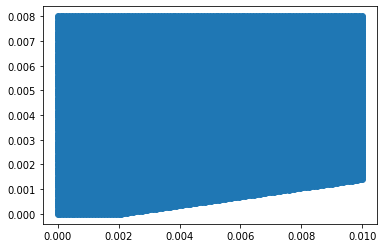

In [5]:
cfd_data=np.hstack((X,Y,Pressure,Rho,x_velocity,y_velocity,temperature,mach_number))
print(cfd_data.shape)

plt.scatter(cfd_data[:,[0]],cfd_data[:,[1]])

In [6]:
## Initial Values
Initial_Values=[]
for i in range(len(cfd_data)):
    if cfd_data[i,[0]]==0:
        Initial_Values.append(cfd_data[i])
Initial_Values=np.array(Initial_Values)

##---------------##-------------------##----------------##

## Boundary Values
Boundary_Values=[]
for i in range(len(cfd_data)):
    if cfd_data[i,[0]]==0.01:
        Boundary_Values.append(cfd_data[i])
Boundary_Values=np.array(Boundary_Values)
# print(Boundary_Values.shape)

##--------------##------------------##-----------------##

## Residual Values
Residual_Points=[]
idx=np.random.choice(cfd_data.shape[0],500,replace=False)
Residual_Points=cfd_data[idx,:]

In [7]:
Points_to_be_considered=[]
for i in range(len(Residual_Points)):
    if Residual_Points[i,[1]]>0.001 and Residual_Points[i,[1]]<0.006:
        Points_to_be_considered.append(Residual_Points[i])
        
Points_to_be_considered=np.array(Points_to_be_considered)
Residual_Points=Points_to_be_considered

In [8]:
x_train=np.vstack((Initial_Values[:,0:2],Boundary_Values[:,0:2],Residual_Points[:,0:2]))
#plt.scatter(x_train[:,[0]],x_train[:,[1]])
u_train=np.vstack((Initial_Values[:,2:],Boundary_Values[:,2:],Residual_Points[:,2:]))

u_train_LB=u_train[0]

u_train_UB=u_train[-1]

print(u_train_LB,u_train_UB)

u_train=(u_train-u_train_LB)/(u_train_UB-u_train_LB)

# u_train = [ Pressure, Denisty, x-velocity, y-velocity, temp, mach ]

[1.01e+05 2.47e+00 6.78e+02 0.00e+00 2.86e+02 2.00e+00] [2.45e+05 3.60e+00 5.92e+02 1.04e+02 3.35e+02 1.64e+00]


## Generate Random Points

In [9]:
x_data=np.linspace(0,0.01,100)
y_data=np.linspace(0,0.008,100)

X,Y=np.meshgrid(x_data,y_data)
xy_train=np.hstack((X.flatten()[:,None],Y.flatten()[:,None]))

lb=xy_train[0]
ub=xy_train[-1]

Train_points=lb+(ub-lb)*lhs(2,2000)

In [10]:
ftrainpoints=[]

# Condition y>0.002
for i in range(len(Train_points)):
    if Train_points[i,[1]]>=0.002:
        ftrainpoints.append(Train_points[i])
        
for i in range(len(Train_points)):
    if Train_points[i,[1]]<=0.002 and Train_points[i,[1]]>=0.25*(Train_points[i,[0]]-0.002):
        ftrainpoints.append(Train_points[i])
        
ftrainpoints=np.array(ftrainpoints)
Train_points=ftrainpoints


## Plot the domain

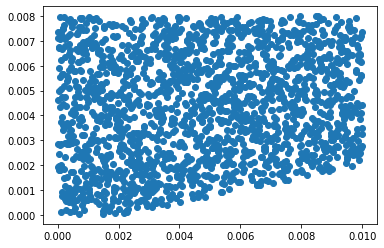

In [11]:
plt.scatter(Train_points[:,[0]],Train_points[:,[1]])

## Plot the Domain

[]

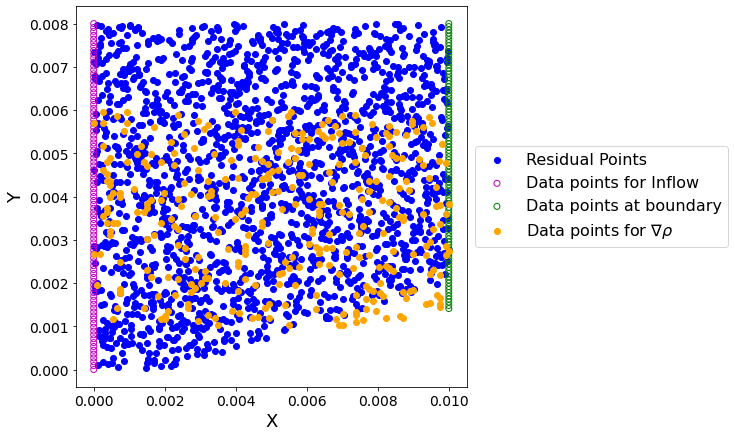

In [12]:
plt.figure(figsize=(7,7))
plt.scatter(Train_points[:,[0]],Train_points[:,[1]],marker='o',color='b',
           label='Residual Points')

plt.scatter(Initial_Values[:,0],Initial_Values[:,1],facecolor='none',
           edgecolor='m',label='Data points for Inflow')
plt.scatter(Boundary_Values[:,[0]],Boundary_Values[:,[1]],facecolor='none',
           edgecolor='g',label='Data points at boundary')
plt.scatter(Residual_Points[:,[0]],Residual_Points[:,[1]],color='orange',
            marker='o',label= r'Data points for $\nabla \rho$')

plt.xlabel("X",fontsize=18)
plt.ylabel("Y",fontsize=18)
plt.tick_params(axis='x',labelsize=14)
plt.tick_params(axis='y',labelsize=14)
plt.legend(loc='center left',bbox_to_anchor=(1,0.5),fontsize=16)
plt.plot()
# savetxt('Train_points.csv',Train_points,delimiter=',')
# savetxt('Initial_Values.csv',Initial_Values,delimiter=',')
# savetxt('Boundary_Values.csv',Boundary_Values,delimiter=',')
# savetxt('Residual_Points.csv',Residual_Points,delimiter=',')

In [13]:
X_f_train=np.vstack((Train_points,x_train))
# print(Train_points.shape)

## Convert float to Tensor

In [14]:
x_train=torch.from_numpy(x_train).float().to(device)
u_train=torch.from_numpy(u_train).float().to(device)
X_f_train=torch.from_numpy(X_f_train).float().to(device)

f_hat=torch.zeros(X_f_train.shape[0],1).float().to(device)

print("x_train:",x_train.shape)
print("u_train:",u_train.shape)
print("X_f_train:",X_f_train.shape)
print("f_hat:",f_hat.shape)


x_train: torch.Size([508, 2])
u_train: torch.Size([508, 6])
X_f_train: torch.Size([2313, 2])
f_hat: torch.Size([2313, 1])


## Class PINNs

In [15]:
class Qblique(nn.Module):
    
    def __init__(self,layers):
        
        super().__init__()
        
        self.activation=nn.Tanh()
        self.MSELoss=nn.MSELoss(reduction='mean')
        self.linears=nn.ModuleList([nn.Linear(layers[i],layers[i+1]) for i in range(len(layers)-1)])
        self.iter=0
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data,gain=5/3)
            nn.init.zeros_(self.linears[i].bias.data)
            
    def forward(self,X):
        alpha=0.0001
        if torch.is_tensor(X)==False:
            X=torch.from_numpy(X).float()
        
        LLimit=torch.from_numpy(lb).float().to(device)
        ULimit=torch.from_numpy(ub).float().to(device)
        
        X=(X-LLimit)/(ULimit-LLimit)
        
        a=X.float()
        
        p_pred=torch.cat((a[:,[0]],a[:,[1]]),1)
        rho_pred=torch.cat((a[:,[0]],a[:,[1]]),1)
        u_pred=torch.cat((a[:,[0]],a[:,[1]]),1)
        v_pred=torch.cat((a[:,[0]],a[:,[1]]),1)
        
        for i in range(len(layers)-2):
            z1=self.linears[i](p_pred)
            z2=self.linears[i](rho_pred)
            z3=self.linears[i](u_pred)
            z4=self.linears[i](v_pred)
            
            p_pred=self.activation(z1)
            rho_pred=self.activation(z2)
            u_pred=self.activation(z3)
            v_pred=self.activation(z4)
            
        p_pred=self.linears[-1](p_pred)
        rho_pred=self.linears[-1](rho_pred)
        u_pred=self.linears[-1](u_pred)
        v_pred=self.linears[-1](v_pred)
        
        # +ve 
        for i in range(len(p_pred)):
            if p_pred[i,[0]]<=0:
                p_pred[i,[0]]=alpha
                
            if p_pred[i,[1]]<=0:
                p_pred[i,[1]]=alpha
                
        a=torch.cat((p_pred,rho_pred,u_pred,v_pred),1)
        
        return a
    
    def LossBC(self,X,Y):
        
        Pred_Val=self.forward(X)
        
        Pred_P=Pred_Val[:,[0]]
        Pred_Rho=Pred_Val[:,[1]]
        Pred_U=Pred_Val[:,[2]]
        Pred_V=Pred_Val[:,[3]]
        
        Loss_P=self.MSELoss(Pred_P,Y[:,[0]])
        Loss_Rho=self.MSELoss(Pred_Rho,Y[:,[1]])
        Loss_U=self.MSELoss(Pred_U,Y[:,[2]])
        Loss_V=self.MSELoss(Pred_V,Y[:,[3]])
        
        LOSS_BC = Loss_P + Loss_Rho + Loss_U + Loss_V
        
        return LOSS_BC
    
    def LossPDE(self,x_to_train_f):
        
        # air
        gamma=1.4
        
        g=x_to_train_f.clone()
        g.requires_grad=True
        
        PRHOUV=self.forward(g)
        
        P=PRHOUV[:,[0]]
        RHO=PRHOUV[:,[1]]
        U=PRHOUV[:,[2]]
        V=PRHOUV[:,[3]]
        
        P_xy=autograd.grad(RHO,g,torch.ones([x_to_train_f.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        P_x=P_xy[:,[0]]
        P_y=P_xy[:,[1]]
        
        Rho_xy=autograd.grad(RHO,g,torch.ones([x_to_train_f.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        Rho_x=Rho_xy[:,[0]]
        Rho_y=Rho_xy[:,[1]]
        
        U_xy=autograd.grad(U,g,torch.ones([x_to_train_f.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        U_x=U_xy[:,[0]]
        U_y=U_xy[:,[1]]
        
        V_xy=autograd.grad(V,g,torch.ones([x_to_train_f.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        V_x=V_xy[:,[0]]
        V_y=V_xy[:,[1]]
        
        # Energy equation
        E=(P)/(RHO*(gamma-1))+0.5*(U**2+V**2)
        
        E_xy=autograd.grad(E,g,torch.ones([x_to_train_f.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        E_x=E_xy[:,[0]]
        E_y=E_xy[:,[1]]
        
        # Entropy
        s=torch.log10(P/pow(RHO,1.4))
        
        # Conservation of mass
        F1=U*Rho_x + RHO*(U_x+V_y) + V*Rho_y
        
         # Conservation of Momentum
        F2 = P_x + 2*RHO*U*U_x + (U**2)*Rho_x + RHO*(U*V_x + V*U_y) + U*V*Rho_y
        F3 = RHO*V*U_x + RHO*U*V_x + P_y + 2*RHO*V*V_y + (V**2)*Rho_y + U*V*Rho_x
        
        # Conservation of energy
        F4 = P*(U_x) + U*P_x + RHO*(E*U_x+U*E_x) + U*E*Rho_x + P*V_y + V*P_y + RHO*(E*V_y+V*E_y) + V*E*Rho_y
        F5 = (P)/(RHO*(gamma-1)) + 0.5*(U**2+V**2) - E
        
        # Loss for each equations
        LossF1=self.MSELoss(F1,f_hat)
        LossF2=self.MSELoss(F2,f_hat)
        LossF3=self.MSELoss(F3,f_hat)
        LossF4=self.MSELoss(F4,f_hat)
        LossF5=self.MSELoss(F5,f_hat)
        LossF6=self.MSELoss(s,f_hat)
        
        # Sum of Losses
        LossPDE = LossF1 + LossF2 + LossF3 + LossF4 + LossF5 + LossF6
        
        return LossPDE
    
    def Loss(self,X,Y,x_to_train_f):
        Loss1=self.LossBC(X,Y)
        Loss2=self.LossPDE(x_to_train_f)
        
        #print("Loss1:",Loss1)
        #print("Loss2:",Loss2)
        
        Total_Loss=Loss1+Loss2
        
        # Saving the Data
#         file1=open('BC_LOSS.txt','a')
#         file1.write(str(Loss1.item())+'\n')
#         file1.close()

        
        return Loss1
    
    def Closure(self):
        
        optimizer.zero_grad()
        
        loss=self.Loss(x_train,u_train,X_f_train)
        
        loss.backward()
        
        self.iter+=1
        
        if self.iter%100==0:
            print("Total Loss:",loss)
        
        return loss
    
    def Test(self,Test_data):
        
        Result_Predicted=self.forward(Test_data)
        Result_Predicted=Result_Predicted.detach().cpu().numpy()
        
        Pressure_Pred=Result_Predicted[:,[0]]
        Density_Pred=Result_Predicted[:,[1]]
        U_Velocity=Result_Predicted[:,[2]]
        V_Velocity=Result_Predicted[:,[3]]
        
        return [Pressure_Pred, Density_Pred, U_Velocity, V_Velocity]
    

## Main Function

In [16]:
layers=[2,40,40,40,40,4]

O=Qblique(layers)

O.to(device)

params=list(O.parameters())

# 1st optimization
optimizer=optim.LBFGS(O.parameters(),lr=0.1,max_iter=5000,
                     tolerance_grad=1e-12,max_eval=None,tolerance_change=1e-10,
                     history_size=1000,line_search_fn='strong_wolfe')


# Back proparation
start_time=time.time()
optimizer.step(O.Closure)
Training_time1=time.time()-start_time

print("Training Time:", Training_time1)

Total Loss: tensor(0.0038, device='cuda:0', grad_fn=<AddBackward0>)
Total Loss: tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
Total Loss: tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
Total Loss: tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
Total Loss: tensor(8.4217e-05, device='cuda:0', grad_fn=<AddBackward0>)
Total Loss: tensor(6.5627e-05, device='cuda:0', grad_fn=<AddBackward0>)
Total Loss: tensor(5.5819e-05, device='cuda:0', grad_fn=<AddBackward0>)
Total Loss: tensor(4.9872e-05, device='cuda:0', grad_fn=<AddBackward0>)
Total Loss: tensor(4.5950e-05, device='cuda:0', grad_fn=<AddBackward0>)
Total Loss: tensor(4.3393e-05, device='cuda:0', grad_fn=<AddBackward0>)
Total Loss: tensor(3.9183e-05, device='cuda:0', grad_fn=<AddBackward0>)
Total Loss: tensor(3.6752e-05, device='cuda:0', grad_fn=<AddBackward0>)
Total Loss: tensor(3.4809e-05, device='cuda:0', grad_fn=<AddBackward0>)
Total Loss: tensor(3.2230e-05, device='cuda:0', grad_fn=<AddBackward0>)
Total Lo

## Test Case 1

In [17]:
x_test1=np.linspace(0,0.012,100)
y_test1=np.array([0.004]*100)

xy_test1=np.hstack((x_test1[:,None],y_test1[:,None]))

test_data1=torch.from_numpy(xy_test1).float().to(device)

In [18]:
[P_Pred_1,Rho_Pred_1,U_Pred_1,V_Pred_1]=O.Test(test_data1)

- Pressure

In [19]:
test_data1=test_data1.detach().cpu().numpy()

In [20]:
P_Pred_1=P_Pred_1*(u_train_UB[0]-u_train_LB[0])+(u_train_LB[0])

Text(0.5, 1.0, 'Pressure Plot')

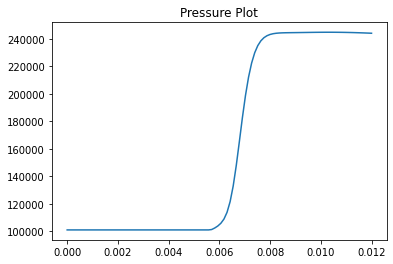

In [21]:
plt.plot(test_data1[:,[0]],P_Pred_1)
plt.title("Pressure Plot")

In [22]:
Rho_Pred_1=Rho_Pred_1*(u_train_UB[1]-u_train_LB[1])+u_train_LB[1]

Text(0.5, 1.0, 'Density Plot')

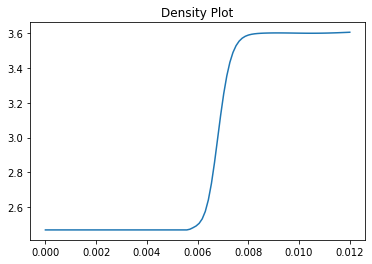

In [23]:
plt.plot(test_data1[:,[0]],Rho_Pred_1)
plt.title("Density Plot")

In [24]:
U_Pred_1=U_Pred_1*(u_train_UB[2]-u_train_LB[2])+u_train_LB[2]

Text(0.5, 1.0, 'U Velocity Plot')

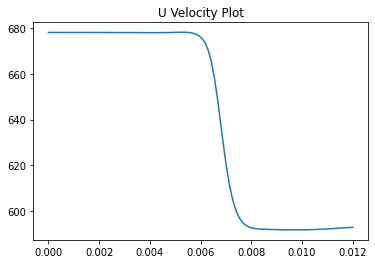

In [25]:
plt.plot(test_data1[:,[0]],U_Pred_1)
plt.title("U Velocity Plot")

In [26]:
V_Pred_1=V_Pred_1*(u_train_UB[3]-u_train_LB[3])+u_train_LB[3]

Text(0.5, 1.0, 'V Velocity Plot')

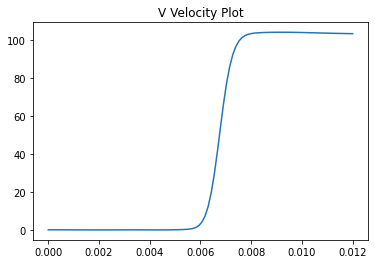

In [27]:
plt.plot(test_data1[:,[0]],V_Pred_1)
plt.title("V Velocity Plot")

---
---

## Saving Data Files

In [57]:
df=pd.read_csv("E:\Oblique_Shock\DATA_FILE_LOW.csv")

X_test=df[["x-coordinate"]].to_numpy()

Y_test=df[["y-coordinate"]].to_numpy()


In [58]:
TEST_DATA=np.hstack((X_test,Y_test))

In [59]:
print(TEST_DATA.shape)
TEST_DATA=torch.from_numpy(TEST_DATA).float().to(device)

(9737, 2)


In [60]:
[P_Pred_1,Rho_Pred_1,U_Pred_1,V_Pred_1]=O.Test(TEST_DATA)

In [61]:
P_Pred_1=P_Pred_1*(u_train_UB[0]-u_train_LB[0])+(u_train_LB[0])

In [62]:
Rho_Pred_1=Rho_Pred_1*(u_train_UB[1]-u_train_LB[1])+u_train_LB[1]

In [63]:
U_Pred_1=U_Pred_1*(u_train_UB[2]-u_train_LB[2])+u_train_LB[2]

In [64]:
V_Pred_1=V_Pred_1*(u_train_UB[3]-u_train_LB[3])+u_train_LB[3]

In [51]:
savetxt('P_Pred_1.csv',P_Pred_1,delimiter=',')

In [52]:
TEST_DATA=TEST_DATA.detach().cpu().numpy()

savetxt('TEST_DATA.csv',TEST_DATA,delimiter=',')

In [53]:
savetxt('Rho_Pred_1.csv',Rho_Pred_1,delimiter=',')

In [54]:
savetxt('U_Pred_1.csv',U_Pred_1,delimiter=',')
savetxt('V_Pred_1.csv',V_Pred_1,delimiter=',')

In [65]:
Pressure_Exact=df[["pressure"]].to_numpy()
#print(Pressure_Exact.shape)
Density_Exact=df[["density"]].to_numpy()
X_Velocity_Exact=df[["x-velocity"]].to_numpy()
Y_Velocity_Exact=df[["y-velocity"]].to_numpy()

## Relative error
P_error=[]
Rho_error=[]
U_error=[]
V_error=[]

for i in range(len(P_Pred_1)):
    P_error.append((Pressure_Exact[i,0]-P_Pred_1[i])/(Pressure_Exact[i,0]))
    Rho_error.append((Density_Exact[i,0]-Rho_Pred_1[i])/(Density_Exact[i,0]))
    U_error.append((X_Velocity_Exact[i,0]-U_Pred_1[i])/(X_Velocity_Exact[i,0]))
    V_error.append((Y_Velocity_Exact[i,0]-V_Pred_1[i])/(Y_Velocity_Exact[i,0]))

P_error=np.array(P_error)
Rho_error=np.array(Rho_error)
U_error=np.array(U_error)
V_error=np.array(V_error)


C:\Users\joshi\AppData\Local\Temp\ipykernel_3608\2290538128.py:17: RuntimeWarning: divide by zero encountered in divide
  V_error.append((Y_Velocity_Exact[i,0]-V_Pred_1[i])/(Y_Velocity_Exact[i,0]))


In [66]:
savetxt('P_error.csv',P_error,delimiter=',')
savetxt('Rho_error.csv',Rho_error,delimiter=',')
savetxt('U_error.csv',U_error,delimiter=',')
savetxt('V_error.csv',V_error,delimiter=',')